## Redes Neurais Artificiais 2025.1

- **Disciplina**: Redes Neurais Artificiais 2025.1  
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  

## Equipe:

1. Afonso Henrique Torres Lucas | ifonso.developer@gmail.com | iFonso - 2215080047
2. Emanuelle Rocha Marreira | emanuellemarreira@gmail.com | emanuellemarreira - 2215080035
3. Erik Gustavo Lima de Oliveira | erik.exatas10@gmail.com | ErikExatas - 2115080049
4. David Augusto De Oliveira E Silva | david-augusto-silva - 2115080006
5. Ítalo Ferreira Fonseca | ItaloFonseca - 2215080012
6. João Vitor Silva De Carvalho | joaov1524@gmail.com | joaocarvalhov - 2215080040
7. Lilian Iazzai De Souza Oliveira | lilianiazzai@gmail.com | lilianiazzai - 2215080018
8. Vitor Nascimento Aguiar | Vtaguiar1909 - 2115080055
9. Afonso Ramos Garcia Neto | afonso.ramos3180@gmail.com | afonso3180 - 1615080003

- **Github**: https://github.com/emanuellemarreira/image-authenticity-classification/tree/parte1

In [1]:
# bibliotecas
import matplotlib.pyplot as plt
import tensorflow as tf
import torch

from collections import Counter

## Descrição do problema

A qualidade de imagens geradas por inteligência artificial tem rapidamente aumentado, levando a preocupação da autenticidade e da segurança dos dados levantados. Isso ocorre pelo aumento gradativo de melhores modelos de inteligência, gerando fotos fiéis ao que o olho humano intepreta como real. Essas imagens geradas artifialmente estão no pódio a disputar com imagens geradas por humanos. Com isso, o dataset CIFAKE foi proposto como uma base para a tarefa de classificação binária de imagens: distinguir entre imagens reais e imagens sintéticas geradas por IA. Ele combina 60.000 imagens reais do dataset CIFAR-10 (um conjunto de imagens de baixa resolução amplamente utilizado em tarefas de aprendizado de máquina) com 60.000 imagens sintéticas geradas por modelos de difusão latente (Stable Diffusion).

As imagens têm resolução de 32×32 pixels e estão distribuídas em 10 classes: avião, automóvel, pássaro, gato, cervo, cachorro, sapo, cavalo, navio e caminhão.

O objetivo do modelo é classificar cada imagem como real ou falsa (gerada por IA).

## Pré-processamento

A etapa de pré-processamento está mais definida em `src/utils/data_utils_keras.py`
Mas, temos a seguinte função:

```python
class ModelType(Enum):
    GENERAL = "general"
    EFFICIENTNET_B0 = "efficientnet_b0"
    RESNET50 = "resnet50"
    XCEPTION = "xception"
    MOBILENET_V2 = "mobilenet_v2"
    SHUFFLENET_V2 = "shufflenet_v2"


def _get_tf_preprocess_fn(model_type: ModelType,
                          resize_to: Tuple[int, int]) -> Callable[[tf.Tensor, tf.Tensor], Tuple[tf.Tensor, tf.Tensor]]:
    """
    Retorna função de preprocessing para ser aplicada no map() do tf.data.Dataset
    """
    def preprocess(image: tf.Tensor, label: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        image = tf.image.resize(image, resize_to)
        image = tf.cast(image, tf.float32) / 255.0

        if model_type in [ModelType.EFFICIENTNET_B0, ModelType.RESNET50]:
            mean = tf.constant([0.485, 0.456, 0.406])
            std = tf.constant([0.229, 0.224, 0.225])
            image = (image - mean) / std

        elif model_type == ModelType.XCEPTION:
            # Normalização para [-1, 1]
            image = (image - 0.5) * 2.0

        elif model_type == ModelType.MOBILENET_V2:
            image = (image - 0.5) * 2.0 

        elif model_type == ModelType.SHUFFLENET_V2:
            image = tf.cast(image, tf.float32) / 255.0  # o mesmo que GENERAL


        return image, label

    return preprocess


def load_and_preprocess_data_tf(resize_to: Tuple[int, int] = (224, 224),
                                batch_size: int = 32,
                                model_type: ModelType = ModelType.GENERAL) -> Tuple[tf.data.Dataset, tf.data.Dataset]:

    train_path = "../data/train"
    test_path = "../data/test"

    if not _is_dataset_present():
        path = dataset_download(__ONLINE_DATASET_URI)
        train_path = f"{path}/cifake/train"
        test_path = f"{path}/cifake/test"

    preprocess_fn = _get_tf_preprocess_fn(model_type, resize_to)

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=resize_to,
        batch_size=batch_size,
        shuffle=True
    ).map(preprocess_fn).prefetch(tf.data.AUTOTUNE)

    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_path,
        image_size=resize_to,
        batch_size=batch_size,
        shuffle=False
    ).map(preprocess_fn).prefetch(tf.data.AUTOTUNE)

    return train_ds, test_ds
```

Inicialmente, é definida uma transformação para os dados carregados baseada no tipo de modelo especificado através do enum ModelType. O redimensionamento das imagens varia conforme o modelo: EfficientNet-B0 e ResNet50 utilizam 224×224 pixels, enquanto Xception utiliza 299×299 pixels como tamanho padrão, embora todos os modelos aceitem tamanhos customizados através do parâmetro resize_to.

Em seguida, é aplicada a transformação ToTensor() que converte as imagens do formato padrão PIL `[altura, largura, canais]` para o formato `[canais, altura, largura]` utilizado pelo PyTorch, além de normalizar os valores de pixel de 0–255 para o intervalo `[0.0, 1.0]`.

A normalização subsequente varia significativamente entre os modelos: EfficientNet-B0 e ResNet50 aplicam a normalização ImageNet padrão com médias `[0.485, 0.456, 0.406]` e desvios padrão `[0.229, 0.224, 0.225]`, mantendo os valores aproximadamente no intervalo `[-2.1, 2.6]`. O Xception, por sua vez, utiliza uma normalização diferenciada com médias e desvios padrão de `[0.5, 0.5, 0.5]`, convertendo os valores do intervalo `[0.0, 1.0]` para `[-1.0, 1.0]`, que é específico da arquitetura deste modelo.

Opcionalmente, caso o parâmetro keras_format seja ativado, é aplicada uma transformação adicional que altera o formato do tensor de `[canais, altura, largura]` para `[altura, largura, canais]`, padrão no TensorFlow/Keras, facilitando a integração com modelos pré-treinados dessas bibliotecas.

Nosso conjunto de dados é composto por duas classes: imagens reais e imagens geradas artificialmente. A seguir, temos as classes:

In [2]:
from utils import data_utils_keras

image_size = (32, 32)
train_data, test_data = data_utils_keras.load_and_preprocess_data_tf(resize_to=image_size, 
                                                                     batch_size=1)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [3]:
print(f"Dados:\n\ntreino: {len(train_data)} \nteste: {len(test_data)}")

Dados:

treino: 100000 
teste: 20000


In [4]:
fake_class_data_count = 0
real_class_data_count = 0

for _, labels in train_data:
    fake_class_data_count += tf.reduce_sum(tf.cast(labels == 1, tf.int32)).numpy()
    real_class_data_count += tf.reduce_sum(tf.cast(labels == 0, tf.int32)).numpy()

print(f"Quantidade de dados de treino:\nlabel 'REAL': {real_class_data_count} \nlabel 'FAKE': {fake_class_data_count}")

Quantidade de dados de treino:
label 'REAL': 50000 
label 'FAKE': 50000


2025-06-09 21:50:00.779054: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Visualização dos dados

A seguir, temos uma mostra da distribuição das classes do dataset, bem como uma visualização de algumas imagens do dataset, extraídas do conjunto de treinamento. 

### Histograma de distribuição das classes 

O histograma permite a a visualização da distribuição das classes de imagens ```FAKE``` e ```REAL```. 

2025-06-09 21:50:07.243971: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


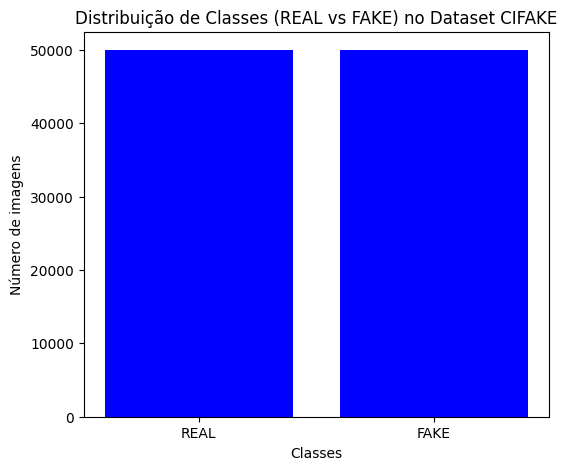

In [5]:
all_labels = []

for _, labels in train_data:
    all_labels.extend(labels.numpy().tolist())

label_count = Counter(all_labels)
binary_class_names = ['REAL', 'FAKE']
frequencies = [label_count[i] for i in range(len(binary_class_names))]

plt.figure(figsize=(6, 5))
plt.bar(binary_class_names, frequencies, color='blue', tick_label=binary_class_names)
plt.xlabel('Classes')
plt.ylabel('Número de imagens')

plt.title('Distribuição de Classes (REAL vs FAKE) no Dataset CIFAKE')

plt.show()

Nota-se que as classes de imagens seguem uma distribuição uniforme, já que a quantidade de exemplos para cada classe é igual.

### Grid de imagens representativas

O grid de imagens representativas mostra exemplos do conjunto de dados para cada classse.

In [6]:
# Junta todos os batches em um único tensor
images, labels = next(iter(train_data))

all_images = []
all_labels = []

for batch_images, batch_labels in train_data:
    all_images.append(batch_images)
    all_labels.append(batch_labels)

images = tf.concat(all_images, axis=0)
labels = tf.concat(all_labels, axis=0)

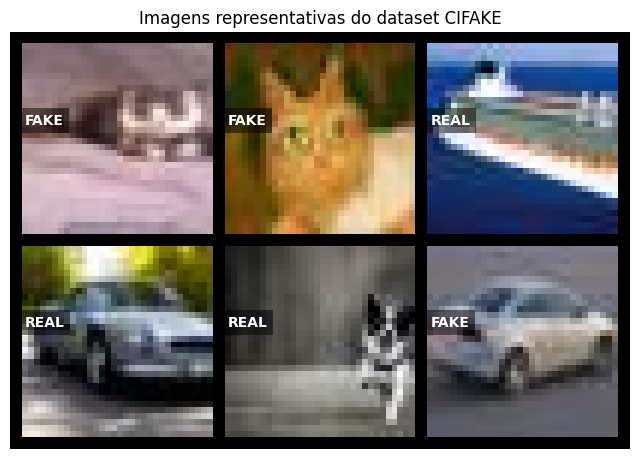

In [7]:
from torchvision.utils import make_grid

images = torch.from_numpy(images.numpy()).permute(0, 3, 1, 2).float()
labels = torch.from_numpy(labels.numpy()).long()

images, labels = images[:6], labels[:6]

grid = make_grid(images, nrow=3, padding=2)
npimg = grid.permute(1, 2, 0).numpy()

plt.figure(figsize=(8, 6))
plt.imshow(npimg)
plt.axis('off')
plt.title('Imagens representativas do dataset CIFAKE')

num_images = len(images)
rows = 2
cols = 3
img_height, img_width = images.shape[2], images.shape[3]
padding = 2

label_map = {0: 'REAL', 1: 'FAKE'}

for i in range(num_images):
    row = i // cols
    col = i % cols
    x = col * (img_width + padding) + padding
    y = row * (img_height + padding) + 15

    plt.text(x, y,
             label_map[labels[i].item()],
             color='white',
             fontsize=10,
             weight='bold',
             bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))